## Global Spatial Autocorrelation

In [48]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

import shapely

# Analysis
import geopandas
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

- The notion of spatial autocorrelation relates to the existence of a “functional relationship between what happens at one point in space and what happens elsewhere”

- Spatial autocorrelation thus has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations.

- Like a traditional correlation

- Spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in other locations.

### Understanding Spatial Autocorrelation

- Global spatial autocorrelation, on which this chapter is focused on, considers the overall trend that the location of values follows. In doing this, the study of global spatial autocorrelation makes possible statements about the degree of clustering in the dataset. Do values generally follow a particular pattern in their geographical distribution? Are similar values closer to other similar values than we would expect from pure chance? These are some of the questions that relate to global spatial autocorrelation. Local autocorrelation focuses on deviations from the global trend at much more focused levels than the entire map.

### An empirical illustration: the EU Referendum

In 2016, the United Kingdom ran a referendum to decide whether to remain in the European Union or to leave the club, the so called “Brexit” vote. We will use the official data from the Electoral Commission at the local authority level on percentage of votes for the Remain and Leave campaigns. There are two distinct datasets we will combine:

Electoral Commission data on vote percentages at the local authority level. 
ONS Local Authority Districts (December 2016) Generalized Clipped Boundaries in the UK WGS84

In [2]:
brexit_data_path = "./geo_data/brexit/brexit_vote.csv"
ref = pd.read_csv(brexit_data_path, index_col="Area_Code")
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [3]:
lads = geopandas.read_file(
    "./geo_data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int64   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int64   
 4   bng_n       391 non-null    int64   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 41.7+ KB


In [4]:
## Pct_leave measures proportion of votes for the Leave alternative.
# Let's merge the vote results with the spatial data and project the output into the 
#Spherical Mercator coordinate reference system (CRS), preferred choice of web maps


db = (geopandas.GeoDataFrame(lads.join(ref[["Pct_Leave"]]), crs=lads.crs
                            ).to_crs(epsg=3857)[["objectid", "lad16nm", "Pct_Leave", "geometry"]
                                               ].dropna()
)

In [5]:
db.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."


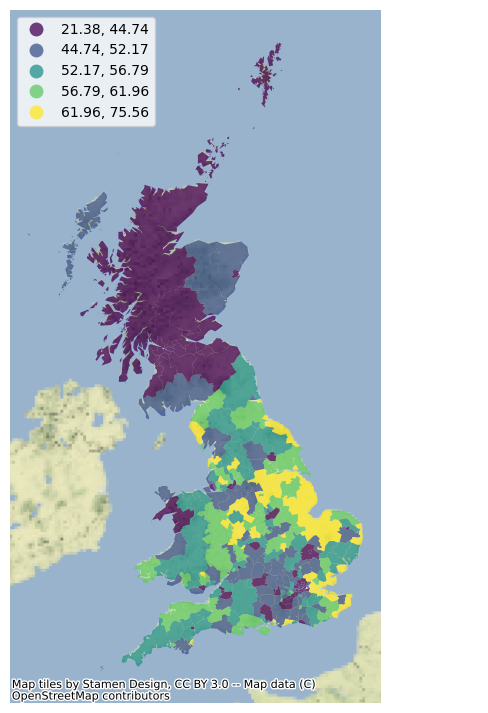

In [6]:
# Generate a choropleth map

f, ax = plt.subplots(1, figsize=(9,9))

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax


)

contextily.add_basemap(ax,
                      crs=db.crs,
                      source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()


- The final piece we need before we can delve into autocorrelation is the spatial weights matrix. We will use eight nearest neighbors for the sake of the example.

In [7]:
# Generate weights from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
w

In [9]:
# Row standardization

w.transform = "R"
w

### Global spatial autocorrelation

The map above is a good way to begin exploring the main spatial patterns in the data. At first sight, it appears to display a fair amount of positive spatial autocorrelation: local authorities with high percentages of votes to leave the EU tend to be next to each other (see, for instance, the eastern region), as are those where a much smaller proportion of their population voted to leave (with Scotland being a good example in the north).

#### Spatial Lag

The spatial lag operator is one of the most common and direct applications of spatial weights matrices (W’s) in spatial analysis. The mathematical definition is the product of 
W and the vector of a given variable. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is akin to a local smoother of a variable.

We can formally express it in matrix notation as:

$$
Y_{sl} = \textbf{W} Y
$$

or, in individual notation as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where $w_{ij}$ is the cell in $\textbf{W}$ on the $i$-th row and $j$-th column, thus capturing the spatial relationship between observations $i$ and $j$. $y_{sl-i}$ thus captures the product of the values and weights of each observation other than $i$ in the dataset. Because non-neighbors receive a weight of zero, $y_{sl-i}$ really captures the product of values and weights for $i$'s neighbors. If $\textbf{W}$ is binary, this will amount to the sum of the values of $i$'s neighbors (useful in some contexts, such as studies of market potential); if $W$ is row standardized, a common transformation, then $w_{ij}$ is bounded between zero and one; the spatial lag thus then becomes a "local average," the average value of $Y$ in the neighborhood of each observation $i$. This latter meaning is the one that will enable our analysis of spatial autocorrelation below.

In [10]:
## Computing spatial lag of a given variable

db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(w,
                                                     db["Pct_Leave"])

In [11]:
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


- First row is Liverpool, one of few locations with less than majority to Leave, second Midlothian in Scotland where no local authority voted to Leave.


- Although both Liverpool and Midlothian display a similar percentage of population who voted to leave (42% and 38%, respectively), the difference in their spatial lags captures the wider geographical context, which are quite different.

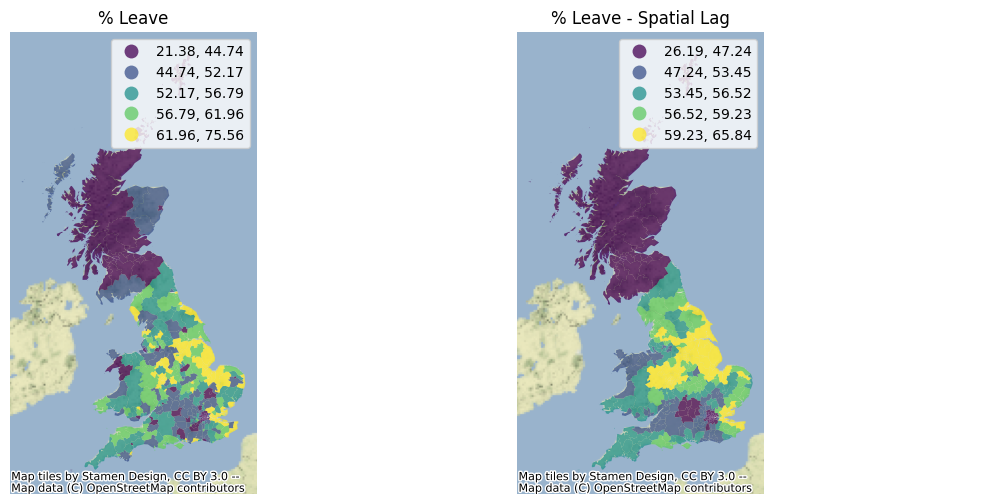

In [18]:
f, axs = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha= 0.75,
    legend=True,
    ax=ax1)

ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)


db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)

ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)

plt.show()


- Big differences on the left between immediate neighbors (as in the case of Liverpool, in the NW of England) are diminished on the map in the right.

### Binary case: join counts

- The spatial lag plays an important role in quantifying spatial autocorrelation. Using it, we can begin to relate the behavior of a variable at a given location to its pattern in the immediate neighborhood.

- Measures of global spatial autocorrelation will then use each observation to construct overall measures about the general trend in a given dataset.

- In this context, we are interested in whether a given observation is surrounded by others within the same category. For example, returning to our dataset, we want to assess the extent to which local authorities who voted to Leave tend to be surrounded by others who also voted to leave. To proceed, let us first calculate a binary variable (Leave) that indicates 1 if the local authority voted to leave, and zero otherwise:

In [20]:
db['Leave'] = (db["Pct_Leave"] > 50).astype(int)
db[['Pct_Leave', 'Leave']].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


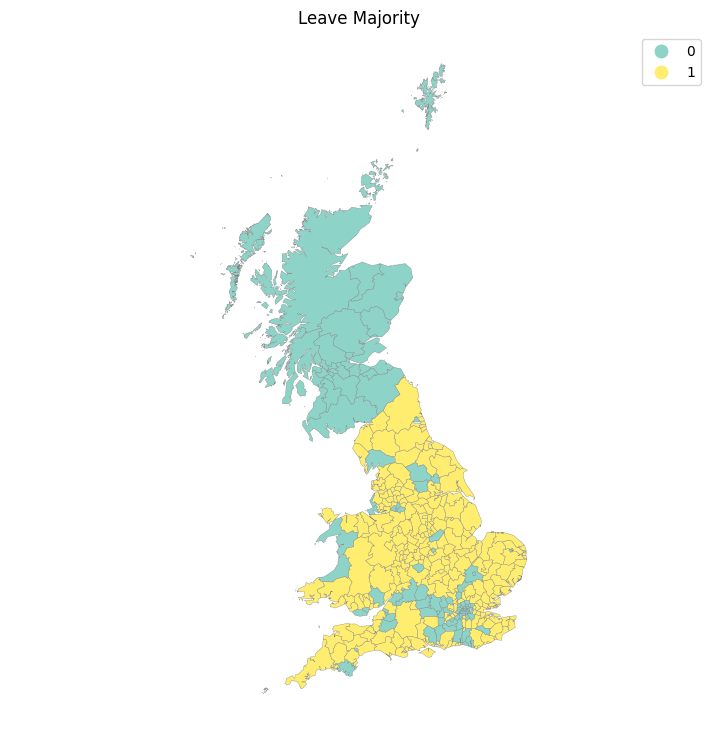

In [21]:
f, ax = plt.subplots(1, figsize=(9,9))
db.plot( 
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9,9))

ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

- Visually, it appears that the map represents a clear case of positive spatial autocorrelation: overall, there are few visible cases where a given observation is surrounded by others in the opposite category.

In [23]:
w.transform

'R'

In [26]:
w.transform = "o"   # non-standardized weight transformation

In [27]:
w.transform

'O'

In [30]:
### Compute the statistic as:
seed(1234)

jc = esda.join_counts.Join_Counts(db["Leave"], w)

In [31]:
jc  #object

In [32]:
jc.bb # how many green "squares" we have

871.0

In [33]:
jc.ww    #how many yellow occurences map have

302.0

In [35]:
jc.bw  # how many GY/YG we have

347.0

In [36]:
#The sum of those three gives us the total number of comparisons:

jc.bb + jc.ww + jc.bw

1520.0

In [37]:
jc.J

1520.0

- The statistic is based on comparing the actual number of joins of each class (bb, ww, bc) with what one would expect in a case of spatial randomness. Those expectations can be accessed as well, for the GG/YY case:

In [38]:
jc.mean_bb

727.4124124124124

In [39]:
jc.mean_bw

649.3233233233233

- Statistical inference to obtain a sense of whether these values are likely to come from random chance or not can be accessed using random spatial permutations of the observed values to create synthetic maps under the null hypothesis of complete spatial randomness. esda generates 999 such synthetic patterns and then uses the distribution of join counts from these patterns to generate pseudo-pvalues for our observed join count statistics:

In [40]:
jc.p_sim_bb

0.001

In [41]:
jc.p_sim_bw

1.0

- These results point to a clear presence of positive spatial autocorrelation, as there are a lot more joins of pairs in the same category than one would expect (p_sim_bb) and significantly less of opposite joins (p_sim_bw). 

### Continuous case: Moran Plot and Moran’s I


- Once we have built some intuition around how spatial autocorrelation can be
    formally assessed in the binary case, let us move to situations where the
    variable of interest does not only take two values, but is instead continuous.
    Probably the most commonly used statistic in this context is Moran's I {cite}`Moran1948`, which can be written as:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

where $n$ is the  number of observations, $z_{i}$ is the standardized value of the variable of interest at location $i$, and $w_{ij}$ is the cell corresponding to the $i$-th row and $j$-th column of a $W$ spatial weights matrix.

- The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, the variable of interest is usually standardized by subtracting its mean:

In [42]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()

In [43]:
db["Pct_Leave_lag_std"] = (db["Pct_Leave_lag"] - db['Pct_Leave_lag'].mean())

In [47]:
db.head(2)

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_lag,Leave,Pct_Leave_std,Pct_Leave_lag_std
lad16cd,,,,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537...",60.92125,1,16.429237,8.120562
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426...",61.02625,1,12.339237,8.225563


#### Moran plot

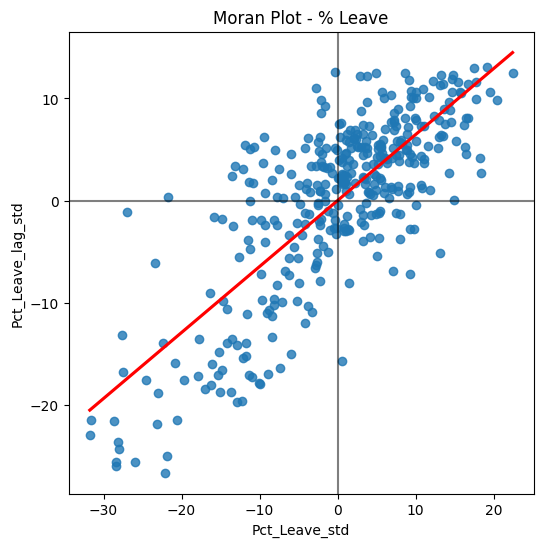

In [50]:
f, ax = plt.subplots(1, figsize=(6,6))

sns.regplot(x= "Pct_Leave_std",
           y="Pct_Leave_lag_std",
           ci=None,
           data=db,
           line_kws = {"color":"r"})
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

   - The figure above displays the relationship between the standardized “Leave” voting percentage in a local authority and its spatial lag which, because the 
        W used is row-standardized, can be interpreted as the average standardized density of the percent Leave vote in the neighborhood of each observation
        
        
- The plot displays a positive relationship between both variables. This is indicates the presence of positive spatial autocorrelation: similar values tend to be located close to each other.

#### Moran I plot

-   Moran’s I can also be interpreted as the slope of the Moran Plot


- To calculate Moran’s I in our dataset, we can call a specific function in esda directly (before that, let us row standardized the w object again):

In [51]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

In [52]:
moran.I

0.6454521298096587

-  esda performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process. This is summarized in the p_sim attribute:

In [53]:
moran.p_sim

0.001

- The value is calculated as an empirical p-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random

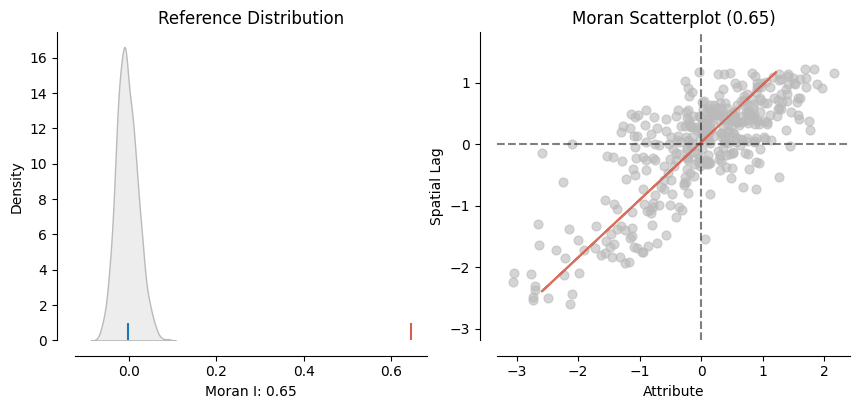

In [54]:
plot_moran(moran);

### Other global indices


Moran's I is probably the most widely used statistic for global spatial autocorrelation, however it is not the only one. In this final part of the chapter, we introduce two additional measures that are common in applied work. Although they all consider spatial autocorrelation, they differ in how the concept is tackled in the specification of each test.

#### Geary's C

The contiguity ratio $c$  is given by:

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

where  𝑛  is the number of observations,  𝑤𝑖𝑗  is the cell in a binary matrix  𝑊  expressing whether  𝑖  and  𝑗  are neighbors ( 𝑤𝑖𝑗=1 ) or not ( 𝑤𝑖𝑗=1 ),  𝑦𝑖  is the  𝑖 -th observation of the variable of interest, and  𝑦¯  is its sample mean. When compared to Moran's I, it is apparent both measures compare the relationship of  𝑌  within each observation's local neighborhood to that over the entire sample. However, there are also subtle differences. While Moran's I takes cross-products on the standardized values, Geary's C uses differences on the values without any standardization.
Computationally, Geary's C is more demanding, but it can be easily computed using esda:

In [55]:
geary = esda.geary.Geary(db["Pct_Leave"], w)

In [56]:
geary.C

0.4080233215854691

- We can perform a simulation that allows us to draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data

In [57]:
geary.p_sim

0.001

#### Getis and Ord's G

Originally proposed by {cite}`Getis1992analysis`, the $G$ is the global version of a family of statistics of spatial autocorrelation based on distance. The $G$ class of statistics is conceived for points, hence the use of a distance $W$, but it can also be applied to polygon data if a binary spatial weights matrix can be constructed. Additionally, it is designed for the study of positive variables with a natural origin. The $G$ can be expressed as follows:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned on the relationship between observations $i$ and $j$ following a distance band criterion. $G$ was originally proposed as a measure of concentration rather than of spatial autocorrelation. As such, it is well suited to test to what extent similar values (either high or low) tend to co-locate. In other words, the $G$ is a statistic of *positive* spatial autocorrelation. This is usually the interest in most Geographic Data Science applications. However, it is important to note that, because $G$ can be understood as a measure of the intensity with which $Y$ is concentrated, the statistic is not able to pick up cases of *negative* spatial autocorrelation.

To illustrate its computation, let us calculate a binary distance band 
W
. To make sure every observation has at least one neighbor, we will use the min_threshold_distance method and project the dataset into the Ordnance Survey CRS (EPSG code 27700), expressed in meters:

In [60]:
db_osgb = db.to_crs(epsg=27700)
db_osgb.head(2)

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_lag,Leave,Pct_Leave_std,Pct_Leave_lag_std
lad16cd,,,,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((447096.980 537151.936, 440052....",60.92125,1,16.429237,8.120562
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((449862.164 521261.140, 446551....",61.02625,1,12.339237,8.225563


In [62]:
pts = db_osgb.centroid
pts


lad16cd
E06000001    POINT (447867.922 531025.488)
E06000002    POINT (450437.590 516498.275)
E06000003    POINT (463904.467 518087.571)
E06000004    POINT (442467.421 518366.124)
E06000010    POINT (509603.439 430774.371)
                         ...              
W06000018    POINT (317027.563 195705.754)
W06000019    POINT (317609.348 208605.300)
W06000021    POINT (339859.603 207911.258)
W06000022    POINT (332837.641 187552.584)
W06000023    POINT (303947.516 270611.165)
Length: 380, dtype: geometry

In [64]:
xys = pd.DataFrame({"X": pts.x, "Y": pts.y})
xys

,X,Y
lad16cd,,
E06000001,447867.921726,531025.488092
E06000002,450437.589820,516498.275267
E06000003,463904.467139,518087.570500
E06000004,442467.420787,518366.123549
E06000010,509603.439458,430774.371033
...,...,...
W06000018,317027.563409,195705.754157
W06000019,317609.347845,208605.300477
W06000021,339859.603249,207911.257641


In [65]:
min_thr = weights.util.min_threshold_distance(xys)
min_thr

180878.918009262

- For every local authority to have a neighbor, the distance band needs to at least be about 181 Km. This information can then be passed to the DistanceBand constructor:

In [66]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

In [68]:
## Calculate global G statistic

gao = esda.getisord.G(db['Pct_Leave'], w_db)
gao

In [69]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.434 | Pseudo P-value: 0.006
